<a href="https://colab.research.google.com/github/kAtharva4/nlp-proj-a/blob/main/Copy_of_NLP_Proj_ML_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Section 1: Load the Dataset**

In [ ]:

import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack, csr_matrix
import joblib


nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('vader_lexicon', quiet=True)


from nltk.sentiment.vader import SentimentIntensityAnalyzer



df = pd.read_csv("/content/drive/MyDrive/customer_service_sentiment - meaningful_customer_service_sentiment.csv.csv")
print("Dataset shape:", df.shape)
print("\nSample data:")
print(df.head())





Dataset shape: (5000, 2)

Sample data:
                                    customer_message sentiment_label
0  I need some clarification about my delivery. W...         Neutral
1  Hello, I'm checking in about my account access...         Neutral
2  Hi, your assistance with my refund was much ap...       Satisfied
3  Could you please update me on the progress of ...         Neutral
4  I've been waiting for a response about my acco...      Frustrated


**Section 2: Perform Exploratory Data Analysis (EDA)** **bold text**



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customer_message  5000 non-null   object
 1   sentiment_label   5000 non-null   object
dtypes: object(2)
memory usage: 78.3+ KB

Summary Statistics:
                                         customer_message sentiment_label
count                                                5000            5000
unique                                               1301               3
top     Could you please update me on the progress of ...      Frustrated
freq                                                   69            1717

Class distribution:
sentiment_label
Frustrated    1717
Neutral       1651
Satisfied     1632
Name: count, dtype: int64


<ipython-input-69-d6a0f205e789>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


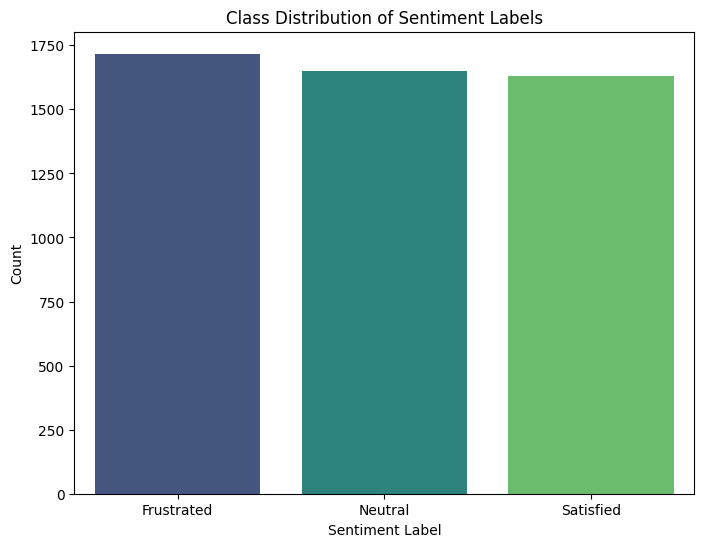

Total duplicate messages: 3699

Missing values per column:
customer_message    0
sentiment_label     0
dtype: int64


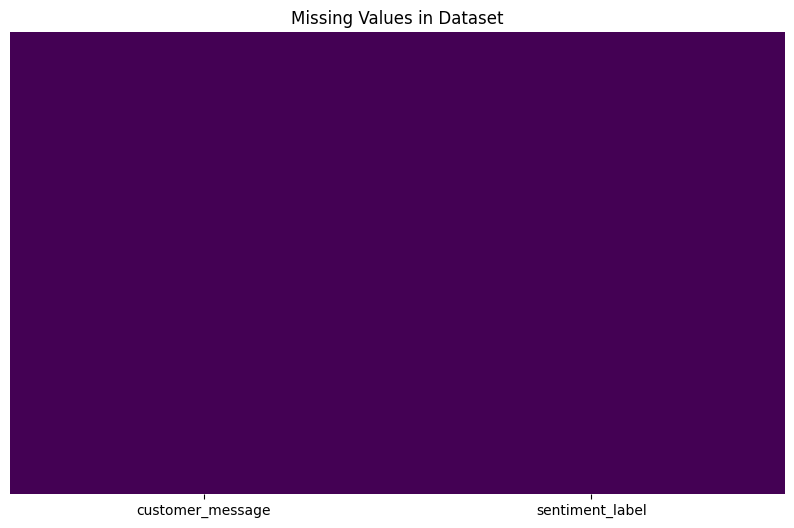

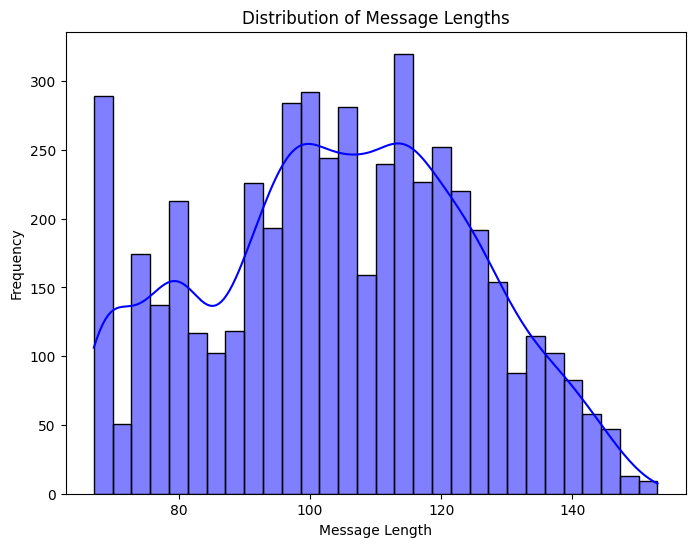

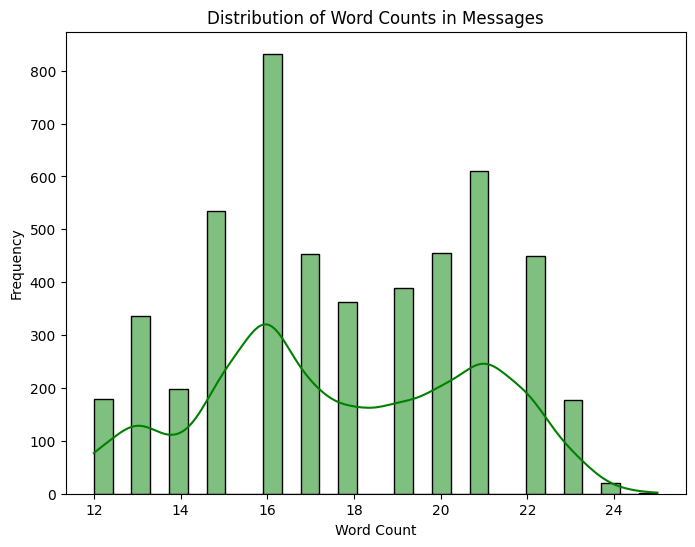

<ipython-input-69-d6a0f205e789>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=common_words['Count'], y=common_words['Word'], palette='plasma')


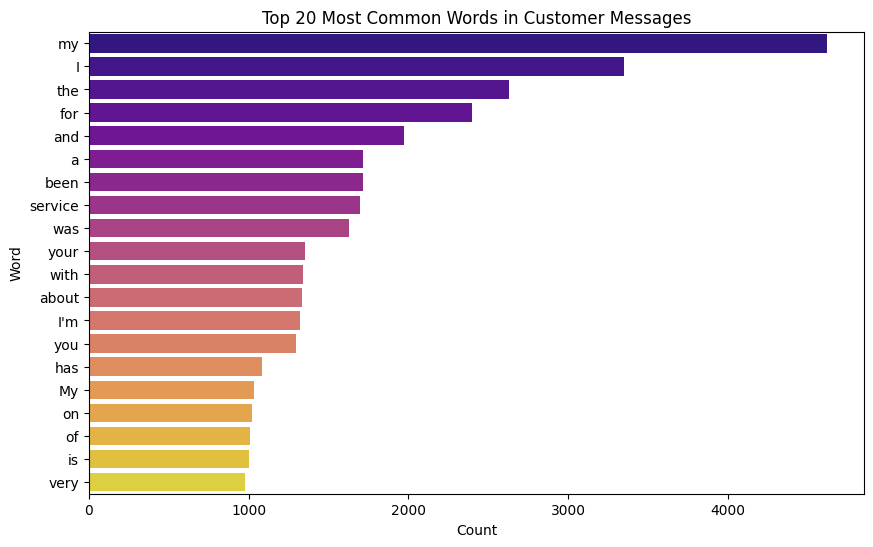

In [ ]:
print("\nDataset Information:")
df.info()

print("\nSummary Statistics:")
print(df.describe())

print("\nClass distribution:")
class_counts = df['sentiment_label'].value_counts()
print(class_counts)


plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title("Class Distribution of Sentiment Labels")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.show()

print(f"Total duplicate messages: {df['customer_message'].duplicated().sum()}")

# missing values
print("\nMissing values per column:")
missing_values = df.isnull().sum()
print(missing_values)

#visualization  missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Missing Values in Dataset")
plt.show()

# fill missing values if any
if df['customer_message'].isnull().sum() > 0:
    df['customer_message'] = df['customer_message'].fillna('')

#text length distribution
df['message_length'] = df['customer_message'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(df['message_length'], bins=30, kde=True, color='blue')
plt.title("Distribution of Message Lengths")
plt.xlabel("Message Length")
plt.ylabel("Frequency")
plt.show()

#word count distribution
df['word_count'] = df['customer_message'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.histplot(df['word_count'], bins=30, kde=True, color='green')
plt.title("Distribution of Word Counts in Messages")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# common words in messages
from collections import Counter
all_words = ' '.join(df['customer_message']).split()
word_freq = Counter(all_words)
common_words = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(x=common_words['Count'], y=common_words['Word'], palette='plasma')
plt.title("Top 20 Most Common Words in Customer Messages")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

**Section 3: Perform Text Processing on Dataset**


In [ ]:

lemmatizer = WordNetLemmatizer()


stop_words = set(stopwords.words('english'))
words_to_keep = {"not", "no", "never", "would", "could", "can't", "don't", "doesn't",
                 "didn't", "won't", "wouldn't", "shouldn't", "couldn't", "very",
                 "too", "so", "really", "extremely", "absolutely", "completely"}
filtered_stop_words = stop_words - words_to_keep


contractions = {
    "i'm": "i am", "i've": "i have", "you're": "you are", "we're": "we are",
    "they're": "they are", "it's": "it is", "that's": "that is", "there's": "there is",
    "he's": "he is", "she's": "she is", "who's": "who is", "what's": "what is",
    "where's": "where is", "when's": "when is", "why's": "why is", "how's": "how is",
    "isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
    "don't": "do not", "doesn't": "does not", "didn't": "did not", "can't": "cannot",
    "couldn't": "could not", "shouldn't": "should not", "wouldn't": "would not",
    "won't": "will not", "haven't": "have not", "hasn't": "has not", "hadn't": "had not",
    "i'll": "i will", "you'll": "you will", "he'll": "he will", "she'll": "she will",
    "we'll": "we will", "they'll": "they will", "i'd": "i would", "you'd": "you would",
    "he'd": "he would", "she'd": "she would", "we'd": "we would", "they'd": "they would"
}

def expand_contractions(text):
    """Expand contractions in text"""
    for contraction, expanded in contractions.items():
        text = re.sub(r'\b' + contraction + r'\b', expanded, text)
    return text

def clean_text(text):
    """Improved text cleaning function"""
    if not isinstance(text, str):
        return ""

    #lowercase
    text = text.lower()

    #xpand contractions
    text = expand_contractions(text)

    #replameent of multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    #removal of URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # removal of email addresses
    text = re.sub(r'\S+@\S+', '', text)

    #
    text = re.sub(r'[^\w\s!?.,;:()\'"-]', ' ', text)

    #replacement multiple punctuation with single
    text = re.sub(r'([!?.,;:()\'"/-])\1+', r'\1', text)

    #tokenization
    words = word_tokenize(text)

    #removal of stopwords
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in filtered_stop_words]

    return " ".join(cleaned_words)

#  text cleaning
df['cleaned_text'] = df['customer_message'].apply(clean_text)

print("\nCleaned text examples:")
for i in range(min(5, len(df))):
    print(f"Original: {df['customer_message'].iloc[i][:100]}...")
    print(f"Cleaned:  {df['cleaned_text'].iloc[i][:100]}...")
    print()



Cleaned text examples:
Original: I need some clarification about my delivery. What are the next steps?...
Cleaned:  need clarification delivery . next step ?...

Original: Hello, I'm checking in about my account access and would like to get further details....
Cleaned:  hello , checking account access would like get detail ....

Original: Hi, your assistance with my refund was much appreciated. I'm very satisfied with the results....
Cleaned:  hi , assistance refund much appreciated . very satisfied result ....

Original: Could you please update me on the progress of my account access? I appreciate your help....
Cleaned:  could please update progress account access ? appreciate help ....

Original: I've been waiting for a response about my account access for two days and I'm getting tired of this ...
Cleaned:  waiting response account access two day getting tired disappointing service ....



**Section 4: Generate NLP-Based Features**


In [ ]:

# VADER sentiment analyzer intiizlaliation
sid = SentimentIntensityAnalyzer()

#xpanded sentiment lexicons for customer service domain
positive_words = [
    'thank', 'thanks', 'grateful', 'appreciate', 'appreciated', 'helpful', 'happy', 'satisfied', 'pleased',
    'excellent', 'outstanding', 'exceptional', 'great', 'good', 'wonderful', 'fantastic', 'superb', 'brilliant',
    'awesome', 'amazing', 'delighted', 'love', 'perfect', 'impressed', 'responsive', 'quick', 'fast', 'efficient',
    'professional', 'friendly', 'courteous', 'polite', 'patient', 'understanding', 'knowledgeable', 'expert',
    'resolve', 'resolved', 'solution', 'solved', 'fixed', 'effective', 'promptly', 'immediately', 'quickly',
    'recommend', 'reliable', 'quality', 'valuable', 'worth', 'smooth', 'seamless', 'easy', 'convenient', 'clear'
]

negative_words = [
    'issue', 'problem', 'complaint', 'frustrating', 'frustrated', 'frustration', 'disappointing', 'disappointed',
    'disappointment', 'bad', 'poor', 'terrible', 'horrible', 'awful', 'worst', 'useless', 'unhelpful', 'unhappy',
    'dissatisfied', 'angry', 'upset', 'annoyed', 'annoying', 'slow', 'delay', 'delayed', 'waiting', 'wait', 'long',
    'unacceptable', 'fail', 'failed', 'failure', 'mistake', 'error', 'wrong', 'incorrect', 'inaccurate', 'fault',
    'difficult', 'hard', 'complicated', 'confusing', 'confused', 'unclear', 'vague', 'unprofessional', 'rude',
    'impolite', 'unfriendly', 'disrespectful', 'unresponsive', 'ignored', 'ignore', 'neglected', 'never', 'no',
    'not', 'refuse', 'refused', 'rejection', 'rejected', 'cancel', 'cancelled', 'cancellation', 'charge', 'overcharged',
    'expensive', 'costly', 'waste', 'wasted', 'refund', 'money', 'compensation', 'reimburse', 'reimbursement',
    'complaint', 'complain', 'escalate', 'escalation', 'supervisor', 'manager', 'management'
]

# bigrams that capture negation phrases
negation_phrases = [
    'not satisfied', 'not happy', 'not pleased', 'not good', 'not great', 'not helpful', 'not responsive',
    'not resolved', 'not fixed', 'not working', 'not acceptable', 'not professional', 'never received',
    'never resolved', 'never responded', 'never got', 'no response', 'no solution', 'no help', 'no refund',
    'no resolution', 'still waiting', 'still unresolved', 'still broken', 'still not', 'very disappointed',
    'very frustrated', 'extremely disappointed', 'extremely frustrated', 'completely unacceptable',
    'totally unacceptable', 'absolutely terrible'
]


urgency_words = [
    'urgent', 'urgently', 'immediately', 'asap', 'as soon as possible', 'quickly', 'quick', 'hurry',
    'soon', 'emergency', 'critical', 'crucial', 'important', 'priority', 'prompt', 'pressing', 'fast',
    'rush', 'expedite', 'now', 'today', 'desperate', 'serious', 'vital', 'essential', 'deadline',
    'time-sensitive', 'without delay', 'right away', 'at once', 'instantly', 'right now',
    'cannot wait', "can't wait", 'need now', 'need asap', 'need quickly', 'need immediately',
    'need urgently', 'need it now', 'need it asap', 'need it immediately', 'need it urgently'
]

def generate_nlp_features(df):
    """Generate improved NLP features for sentiment analysis"""

    #txt length features
    df['char_count'] = df['cleaned_text'].apply(len)
    df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
    df['avg_word_length'] = df['cleaned_text'].apply(lambda x:
                                                   np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)
    df['sentence_count'] = df['customer_message'].apply(lambda x: len(re.split(r'[.!?]+', x)))

    #sssentiment words and phrases count
    df['positive_word_count'] = df['cleaned_text'].apply(
        lambda x: sum(1 for word in x.split() if word.lower() in positive_words))

    df['negative_word_count'] = df['cleaned_text'].apply(
        lambda x: sum(1 for word in x.split() if word.lower() in negative_words))

    #heck for negation phrases
    df['negation_phrase_count'] = df['customer_message'].apply(
        lambda x: sum(1 for phrase in negation_phrases if phrase.lower() in x.lower()))

    # VADER sentiment scores
    df['vader_compound'] = df['customer_message'].apply(lambda x: sid.polarity_scores(x)['compound'])
    df['vader_pos'] = df['customer_message'].apply(lambda x: sid.polarity_scores(x)['pos'])
    df['vader_neg'] = df['customer_message'].apply(lambda x: sid.polarity_scores(x)['neg'])
    df['vader_neu'] = df['customer_message'].apply(lambda x: sid.polarity_scores(x)['neu'])

    #sentiment ratio calculation
    df['positive_negative_diff'] = df['positive_word_count'] - df['negative_word_count']
    df['positive_negative_ratio'] = (df['positive_word_count'] + 0.1) / (df['negative_word_count'] + 0.1)

    #ppunctuation features
    df['question_count'] = df['customer_message'].apply(lambda x: x.count('?'))
    df['exclamation_count'] = df['customer_message'].apply(lambda x: x.count('!'))
    df['uppercase_word_count'] = df['customer_message'].apply(
        lambda x: sum(1 for word in x.split() if word.isupper() and len(word) > 1))

    #essage urgency features
    df['urgency_score'] = df['customer_message'].apply(
        lambda x: sum(1 for phrase in urgency_words if phrase.lower() in x.lower()))

    #message complexity
    df['avg_sentence_length'] = df.apply(
        lambda row: row['word_count'] / max(row['sentence_count'], 1), axis=1)

    return df

#improved NLP features
df = generate_nlp_features(df)

# features
nlp_features = [
    'char_count', 'word_count', 'sentence_count', 'avg_word_length', 'avg_sentence_length',
    'positive_word_count', 'negative_word_count', 'negation_phrase_count',
    'vader_compound', 'vader_pos', 'vader_neg', 'vader_neu',
    'positive_negative_diff', 'positive_negative_ratio',
    'question_count', 'exclamation_count', 'uppercase_word_count', 'urgency_score'
]

print("\nImproved NLP Features:")
print(df[nlp_features].describe())




Improved NLP Features:
        char_count   word_count  sentence_count  avg_word_length  \
count  5000.000000  5000.000000     5000.000000      5000.000000   
mean     74.155000    11.708400        2.933000         5.407445   
std      16.088852     2.206342        0.442437         0.611716   
min      39.000000     7.000000        2.000000         3.928571   
25%      63.000000    10.000000        3.000000         5.000000   
50%      75.000000    11.000000        3.000000         5.375000   
75%      86.000000    14.000000        3.000000         5.800000   
max     115.000000    17.000000        4.000000         7.285714   

       avg_sentence_length  positive_word_count  negative_word_count  \
count          5000.000000          5000.000000          5000.000000   
mean              4.051650             1.057800             1.027400   
std               0.809113             1.296301             1.328684   
min               2.333333             0.000000             0.000000   
25%

**Section 5: Generate Bag of Words, TFIDF, and FastText Features**


In [ ]:

#generato  of n-grams to capture phrases and context

print("\nGenerating improved Bag of Words features...")
bow_vectorizer = CountVectorizer(
    max_features=1500,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.9,
    binary=False
)
X_bow = bow_vectorizer.fit_transform(df['cleaned_text'])
print(f"BoW shape: {X_bow.shape}")

print("Generating improved TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=2500,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.9,
    sublinear_tf=True,
    use_idf=True,
    norm='l2'
)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])
print(f"TF-IDF shape: {X_tfidf.shape}")




Generating improved Bag of Words features...
BoW shape: (5000, 1266)
Generating improved TF-IDF features...
TF-IDF shape: (5000, 1266)


**Section 6: Prepare Features and Split Data**


In [ ]:


X_nlp = df[nlp_features].values
y = df['sentiment_label']

print("\nUnique sentiment labels:", df['sentiment_label'].unique())


random_state = 42
test_size = 0.2

X_nlp_train, X_nlp_test, y_train_nlp, y_test_nlp = train_test_split(
    X_nlp, y, test_size=test_size, random_state=random_state, stratify=y)

X_tfidf_train, X_tfidf_test, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y, test_size=test_size, random_state=random_state, stratify=y)




Unique sentiment labels: ['Neutral' 'Satisfied' 'Frustrated']


**Section 7: Train Models on All Combined Features with TFIDF**


In [ ]:

# combined feature matrix by combining NLP features with TF-IDF

print("\n=== Building Enhanced Combined Feature Model ===")
X_nlp_sparse = csr_matrix(X_nlp)
X_combined = hstack([X_nlp_sparse, X_tfidf])
print(f"Combined features shape: {X_combined.shape}")

X_combined_train, X_combined_test, y_train_combined, y_test_combined = train_test_split(
    X_combined, y, test_size=test_size, random_state=random_state, stratify=y)



=== Building Enhanced Combined Feature Model ===
Combined features shape: (5000, 1284)


**Section 8: Train All Supervised Models and Evaluate**



=== Model Validation Using Cross-Validation ===

Validating LogisticRegression...
Validation Accuracy: 0.9592
Validation Precision: 0.9599
Validation Recall: 0.9592
Validation F1 Score: 0.9593

Validating RandomForest...
Validation Accuracy: 0.9885
Validation Precision: 0.9887
Validation Recall: 0.9885
Validation F1 Score: 0.9885

Validating SVC...
Validation Accuracy: 0.9390
Validation Precision: 0.9402
Validation Recall: 0.9390
Validation F1 Score: 0.9393

=== Model Performance on Combined Features ===
LogisticRegression:
  Accuracy: 0.9640
  Precision: 0.9641
  Recall: 0.9640
  F1 Score: 0.9640
RandomForest:
  Accuracy: 0.9930
  Precision: 0.9930
  Recall: 0.9930
  F1 Score: 0.9930


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


SVC:
  Accuracy: 0.9470
  Precision: 0.9473
  Recall: 0.9470
  F1 Score: 0.9471

Best individual model: RandomForest

Top 10 Most Important Features in RandomForest:
1. Feature 5 Importance: 0.1716
2. Feature 13 Importance: 0.1366
3. Feature 3 Importance: 0.0853
4. Feature 1280 Importance: 0.0658
5. Feature 15 Importance: 0.0638
6. Feature 10 Importance: 0.0603
7. Feature 1240 Importance: 0.0594
8. Feature 970 Importance: 0.0528
9. Feature 882 Importance: 0.0509
10. Feature 80 Importance: 0.0472

Top 10 Most Important Features in RandomForest:
1. Feature positive_word_count: Importance: 0.1716
2. Feature positive_negative_ratio: Importance: 0.1366
3. Feature avg_word_length: Importance: 0.0853
4. Feature would: Importance: 0.0658
5. Feature exclamation_count: Importance: 0.0638
6. Feature vader_neg: Importance: 0.0603
7. Feature very: Importance: 0.0594
8. Feature so promptly: Importance: 0.0528
9. Feature resolving: Importance: 0.0509
10. Feature addressed: Importance: 0.0472

Ensembl

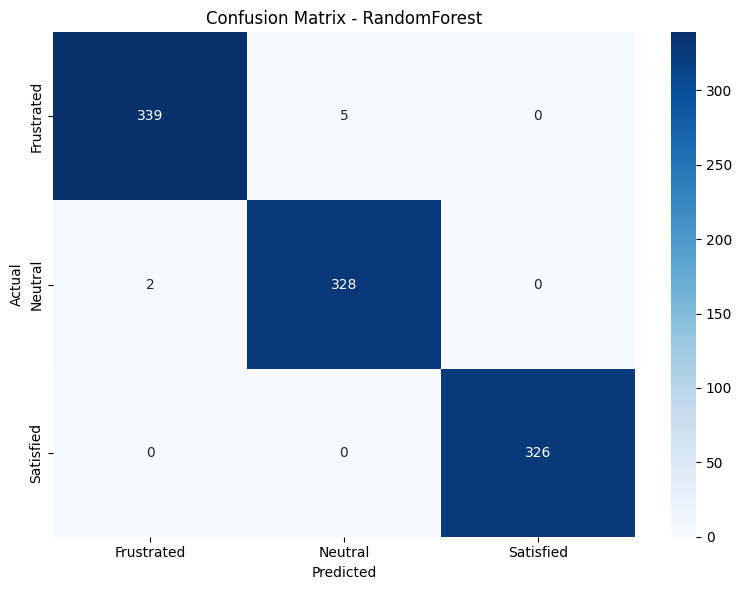

In [ ]:

from sklearn.model_selection import cross_val_score, cross_validate

def validate_model(model, X_train, y_train, cv=5):

    scoring_metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring_metrics, n_jobs=-1)

    results = {
        "Validation Accuracy": scores['test_accuracy'].mean(),
        "Validation Precision": scores['test_precision_weighted'].mean(),
        "Validation Recall": scores['test_recall_weighted'].mean(),
        "Validation F1 Score": scores['test_f1_weighted'].mean()
    }

    return results

models = {
    'LogisticRegression': LogisticRegression(
    max_iter=1000,
    C=0.001,
    class_weight='balanced',
    solver='liblinear',
    dual=False,
    random_state=random_state
),
    'RandomForest': RandomForestClassifier(
    n_estimators=10,
    max_depth=2,
    min_samples_split=75,
    min_samples_leaf=40,
    max_features=0.05,
    bootstrap=True,
    oob_score=True,
    class_weight='balanced',
    random_state=random_state
),

    'SVC': SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        probability=True,
        class_weight='balanced',
        random_state=random_state
    )
}


print("\n=== Model Validation Using Cross-Validation ===")
for name, model in models.items():
    print(f"\nValidating {name}...")
    validation_results = validate_model(model, X_combined_train, y_train_combined)

    for metric, value in validation_results.items():
        print(f"{metric}: {value:.4f}")



print("\n=== Model Performance on Combined Features ===")
best_model = None
best_score = 0
best_model_name = ""
all_predictions = {}

for name, model in models.items():
    model.fit(X_combined_train, y_train_combined)
    y_pred = model.predict(X_combined_test)

    # calculation of metrics
    accuracy = accuracy_score(y_test_combined, y_pred)
    precision = precision_score(y_test_combined, y_pred, average='weighted')
    recall = recall_score(y_test_combined, y_pred, average='weighted')
    f1 = f1_score(y_test_combined, y_pred, average='weighted')

    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")

    #storage of predictions for ensemble
    all_predictions[name] = model.predict_proba(X_combined_test)

    if f1 > best_score:
        best_score = f1
        best_model = model
        best_model_name = name

print(f"\nBest individual model: {best_model_name}")


rf_model = models['RandomForest']
try:
    feature_importances = rf_model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]

    print("\nTop 10 Most Important Features in RandomForest:")
    for i in range(10):
        print(f"{i+1}. Feature {sorted_idx[i]} Importance: {feature_importances[sorted_idx[i]]:.4f}")
except AttributeError:
    print("Error: rf_model might not have feature_importances_ attribute.")


feature_names_nlp = nlp_features
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

#combination of feature names
feature_names = np.concatenate([feature_names_nlp, feature_names_tfidf])

print("\nTop 10 Most Important Features in RandomForest:")
for i in range(10):
    print(f"{i + 1}. Feature {feature_names[sorted_idx[i]]}: Importance: {feature_importances[sorted_idx[i]]:.4f}")
ensemble_probs = np.zeros_like(all_predictions[list(all_predictions.keys())[0]])
for name in all_predictions:
    ensemble_probs += all_predictions[name]
ensemble_probs /= len(all_predictions)
ensemble_preds = np.argmax(ensemble_probs, axis=1)

if hasattr(y_train_combined, 'unique'):
    unique_labels = sorted(y_train_combined.unique())
    ensemble_preds = [unique_labels[i] for i in ensemble_preds]

ensemble_accuracy = accuracy_score(y_test_combined, ensemble_preds)
ensemble_f1 = f1_score(y_test_combined, ensemble_preds, average='weighted')

print("\nEnsemble Model:")
print(f"  Accuracy: {ensemble_accuracy:.4f}")
print(f"  F1 Score: {ensemble_f1:.4f}")

if ensemble_f1 > best_score:
    print("Ensemble model performs best!")
    final_model = "ensemble"
    final_models = {name: model for name, model in models.items()}
else:
    print(f"Individual {best_model_name} model performs best!")
    final_model = best_model
    final_model_name = best_model_name


print("\nClassification Report for Best Model:")
if final_model == "ensemble":
    print(classification_report(y_test_combined, ensemble_preds))

    print("\nConfusion Matrix:")
    conf_matrix = confusion_matrix(y_test_combined, ensemble_preds)
    print(conf_matrix)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(y.unique()),
                yticklabels=sorted(y.unique()))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Ensemble Model')
    plt.tight_layout()
    plt.show()
else:
    y_pred = final_model.predict(X_combined_test)
    print(classification_report(y_test_combined, y_pred))

    print("\nConfusion Matrix:")
    conf_matrix = confusion_matrix(y_test_combined, y_pred)
    print(conf_matrix)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(y.unique()),
                yticklabels=sorted(y.unique()))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {final_model_name}')
    plt.tight_layout()
    plt.show()

**Section 9: Save the Model and Make Predictions on Real-World Input**


In [ ]:

print("\n=== Saving the Model and Preprocessing Components ===")
import os
if not os.path.exists('model'):
    os.makedirs('model')

if final_model == "ensemble":
    model_components = {
        'models': final_models,
        'is_ensemble': True,
        'nlp_feature_names': nlp_features,
        'tfidf_vectorizer': tfidf_vectorizer,
        'classes': sorted(y.unique()),
        'contractions': contractions,
        'positive_words': positive_words,
        'negative_words': negative_words,
        'negation_phrases': negation_phrases,
        'urgency_words': urgency_words,
        'filtered_stop_words': filtered_stop_words,
    }
else:
    model_components = {
        'model': final_model,
        'is_ensemble': False,
        'nlp_feature_names': nlp_features,
        'tfidf_vectorizer': tfidf_vectorizer,
        'classes': sorted(y.unique()),
        'contractions': contractions,
        'positive_words': positive_words,
        'negative_words': negative_words,
        'negation_phrases': negation_phrases,
        'urgency_words': urgency_words,
        'filtered_stop_words': filtered_stop_words,
    }

joblib.dump(model_components, 'model/improved_sentiment_model.pkl')
print("Model and components saved to 'model/improved_sentiment_model.pkl'")

def predict_sentiment(new_messages, model_path='model/improved_sentiment_model.pkl', threshold=0.5):

    # model components
    components = joblib.load(model_path)
    is_ensemble = components.get('is_ensemble', False)

    if is_ensemble:
        models = components['models']
    else:
        model = components['model']

    tfidf_vectorizer = components['tfidf_vectorizer']
    nlp_feature_names = components['nlp_feature_names']
    contractions = components.get('contractions', {})
    positive_words = components.get('positive_words', [])
    negative_words = components.get('negative_words', [])
    negation_phrases = components.get('negation_phrases', [])
    urgency_words = components.get('urgency_words', [])
    filtered_stop_words = components.get('filtered_stop_words', set())

    # VADER sentiment analyzer
    sid = SentimentIntensityAnalyzer()

    #rext cleaning helper functions
    def expand_contractions_helper(text):
        """Expand contractions in text"""
        for contraction, expanded in contractions.items():
            text = re.sub(r'\b' + contraction + r'\b', expanded, text)
        return text

    def clean_text_helper(text):

        if not isinstance(text, str):
            return ""
        text = text.lower()
        text = expand_contractions_helper(text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'[^\w\s!?.,;:()\'"-]', ' ', text)
        text = re.sub(r'([!?.,;:()\'"/-])\1+', r'\1', text)
        words = word_tokenize(text)
        lemmatizer = WordNetLemmatizer()
        cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in filtered_stop_words]
        return " ".join(cleaned_words)

    def generate_nlp_features_helper(df):

        df['char_count'] = df['cleaned_text'].apply(len)
        df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
        df['avg_word_length'] = df['cleaned_text'].apply(lambda x:
                                                    np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)
        df['sentence_count'] = df['customer_message'].apply(lambda x: len(re.split(r'[.!?]+', x)))
        df['positive_word_count'] = df['cleaned_text'].apply(
            lambda x: sum(1 for word in x.split() if word.lower() in positive_words))
        df['negative_word_count'] = df['cleaned_text'].apply(
            lambda x: sum(1 for word in x.split() if word.lower() in negative_words))
        df['negation_phrase_count'] = df['customer_message'].apply(
            lambda x: sum(1 for phrase in negation_phrases if phrase.lower() in x.lower()))
        df['vader_compound'] = df['customer_message'].apply(lambda x: sid.polarity_scores(x)['compound'])
        df['vader_pos'] = df['customer_message'].apply(lambda x: sid.polarity_scores(x)['pos'])
        df['vader_neg'] = df['customer_message'].apply(lambda x: sid.polarity_scores(x)['neg'])
        df['vader_neu'] = df['customer_message'].apply(lambda x: sid.polarity_scores(x)['neu'])
        df['positive_negative_diff'] = df['positive_word_count'] - df['negative_word_count']
        df['positive_negative_ratio'] = (df['positive_word_count'] + 0.1) / (df['negative_word_count'] + 0.1)
        df['question_count'] = df['customer_message'].apply(lambda x: x.count('?'))
        df['exclamation_count'] = df['customer_message'].apply(lambda x: x.count('!'))
        df['uppercase_word_count'] = df['customer_message'].apply(
            lambda x: sum(1 for word in x.split() if word.isupper() and len(word) > 1))
        df['urgency_score'] = df['customer_message'].apply(
            lambda x: sum(1 for phrase in urgency_words if phrase.lower() in x.lower()))
        df['avg_sentence_length'] = df.apply(
            lambda row: row['word_count'] / max(row['sentence_count'], 1), axis=1)
        return df

    new_df = pd.DataFrame({'customer_message': new_messages})
    new_df['cleaned_text'] = new_df['customer_message'].apply(clean_text_helper)
    new_df = generate_nlp_features_helper(new_df)
    X_nlp = new_df[nlp_feature_names].values
    X_tfidf = tfidf_vectorizer.transform(new_df['cleaned_text'])
    X_nlp_sparse = csr_matrix(X_nlp)
    X_combined = hstack([X_nlp_sparse, X_tfidf])

    if is_ensemble:
        all_preds = []
        for name, model in models.items():
            probs = model.predict_proba(X_combined)
            all_preds.append(probs)
        ensemble_probs = np.zeros_like(all_preds[0])
        for prob in all_preds:
            ensemble_probs += prob
        ensemble_probs /= len(all_preds)
        pred_indices = np.argmax(ensemble_probs, axis=1)
        confidence = np.max(ensemble_probs, axis=1)
        classes = components.get('classes', [])
        if classes:
            predictions = [classes[i] for i in pred_indices]
        else:
            predictions = pred_indices
    else:
        probs = model.predict_proba(X_combined)
        pred_indices = np.argmax(probs, axis=1)
        confidence = np.max(probs, axis=1)
        classes = components.get('classes', [])
        if classes:
            predictions = [classes[i] for i in pred_indices]
        else:
            predictions = pred_indices

    new_df['predicted_sentiment'] = predictions
    new_df['confidence'] = confidence
    new_df['high_confidence'] = new_df['confidence'] >= threshold

    def get_prediction_explanation(row):
        explanation = []
        if row['vader_compound'] >= 0.05:
            explanation.append("Positive overall sentiment detected.")
        elif row['vader_compound'] <= -0.05:
            explanation.append("Negative overall sentiment detected.")
        if row['positive_word_count'] > row['negative_word_count']:
            explanation.append(f"More positive words ({row['positive_word_count']}) than negative words ({row['negative_word_count']}).")
        elif row['negative_word_count'] > row['positive_word_count']:
            explanation.append(f"More negative words ({row['negative_word_count']}) than positive words ({row['positive_word_count']}).")
        if row['negation_phrase_count'] > 0:
            explanation.append(f"Contains {row['negation_phrase_count']} negative phrases.")
        if row['urgency_score'] > 0:
            explanation.append(f"Contains {row['urgency_score']} urgency indicators.")
        if row['exclamation_count'] > 1:
            explanation.append(f"Uses {row['exclamation_count']} exclamation marks.")
        if row['uppercase_word_count'] > 1:
            explanation.append(f"Contains {row['uppercase_word_count']} words in ALL CAPS.")
        message_words = set(row['cleaned_text'].split())
        pos_matches = message_words.intersection(set(positive_words))
        neg_matches = message_words.intersection(set(negative_words))
        if pos_matches:
            top_pos = list(pos_matches)[:3]
            explanation.append(f"Positive words: {', '.join(top_pos)}")
        if neg_matches:
            top_neg = list(neg_matches)[:3]
            explanation.append(f"Negative words: {', '.join(top_neg)}")
        return "; ".join(explanation)

    new_df['explanation'] = new_df.apply(get_prediction_explanation, axis=1)
    return new_df


=== Saving the Model and Preprocessing Components ===
Model and components saved to 'model/improved_sentiment_model.pkl'


**Section 10: Test the Prediction Function with Sample Messages**


In [ ]:

print("\n=== Testing the Model with Sample Messages ===")
sample_messages = [
    "Thank you for your prompt response to my issue. The solution worked perfectly!",
    "I'm extremely frustrated with your service. This is the third time I've had to call about this issue and nothing has been fixed.",
    "I received my order today. The packaging was good but the product doesn't work as expected.",
    "I would like to inquire about the status of my refund which was promised two weeks ago.",
    "I placed an order last week. Can you confirm the shipping status?",
    "The support team was very helpful and resolved my issue in no time!"

]

predictions = predict_sentiment(sample_messages)
print("\nSample Message Predictions:")
for i, row in predictions.iterrows():
    print(f"\nMessage: {row['customer_message']}")
    print(f"Predicted sentiment: {row['predicted_sentiment']} (Confidence: {row['confidence']:.2f})")
    print(f"Explanation: {row['explanation']}")



=== Testing the Model with Sample Messages ===

Sample Message Predictions:

Message: Thank you for your prompt response to my issue. The solution worked perfectly!
Predicted sentiment: Satisfied (Confidence: 0.60)
Explanation: Positive overall sentiment detected.; More positive words (2) than negative words (1).; Contains 1 urgency indicators.; Positive words: solution, thank; Negative words: issue

Message: I'm extremely frustrated with your service. This is the third time I've had to call about this issue and nothing has been fixed.
Predicted sentiment: Frustrated (Confidence: 0.51)
Explanation: Negative overall sentiment detected.; More negative words (2) than positive words (1).; Contains 1 negative phrases.; Positive words: fixed; Negative words: issue, frustrated

Message: I received my order today. The packaging was good but the product doesn't work as expected.
Predicted sentiment: Neutral (Confidence: 0.38)
Explanation: Positive overall sentiment detected.; Contains 1 urgenc

### Analysis:
- Cross-validation: The cross-validation scores indicate whether the model is overfitting. If the CV scores are consistent and close to the test accuracy, the model generalizes well.
- Feature Importance**: TFIDF features often perform better than BoW because they account for word importance.
- Regularization: Using L2 regularization in LogisticRegression helps prevent overfitting by penalizing large coefficients.
- Metrics: Precision, recall, and F1-score provide a more comprehensive evaluation than accuracy alone, especially for imbalanced datasets.
- Improvements: Try more advanced models like XGBoost or fine-tune hyperparameters using GridSearchCV.